# A/B Test - Translation 

A France-based users company have a much higher conversion rate in Franch then in any other Frenchspeaking country.
The solution was to have one translation written by a local, aiming to improve the conversion rate However, based on the test the localized translation was doing worse!

The structure of this notebook is as follows:
    1. Load Dataset
    2. Exploratory Data Analysis
    3. Two-sample Z-test on entire dataset
    4. Conversion rate by variables
    5. Conversion rate by country

In [176]:
import  warnings
#warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

# Load Dataset

In [177]:
test = pd.read_csv('test_table.csv', parse_dates=['date'])
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,FR,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,FR,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,FR,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,FR,Google,FireFox,0,1


In [179]:
user = pd.read_csv('user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Democratic Republic of the Congo
1,343561,F,27,Luxembourg
2,118744,M,23,Canada
3,987753,F,27,Switzerland
4,554597,F,20,France


In [180]:
# Merge two tables
data = pd.merge(left=test, right=user, how='left', on='user_id')
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,FR,NaN,IE,1,0,M,32.0,France
1,497851,2015-12-04,Ads,Web,FR,Google,IE,0,1,M,21.0,Democratic Republic of the Congo
2,848402,2015-12-04,Ads,Web,FR,Facebook,Chrome,0,0,M,34.0,France
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Democratic Republic of the Congo
4,548435,2015-11-30,Ads,Web,FR,Google,FireFox,0,1,M,19.0,Democratic Republic of the Congo


# Exploratory Data Analysis

In [181]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 31.1+ MB


In [182]:
test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [183]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [184]:
user.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 45.0+ MB


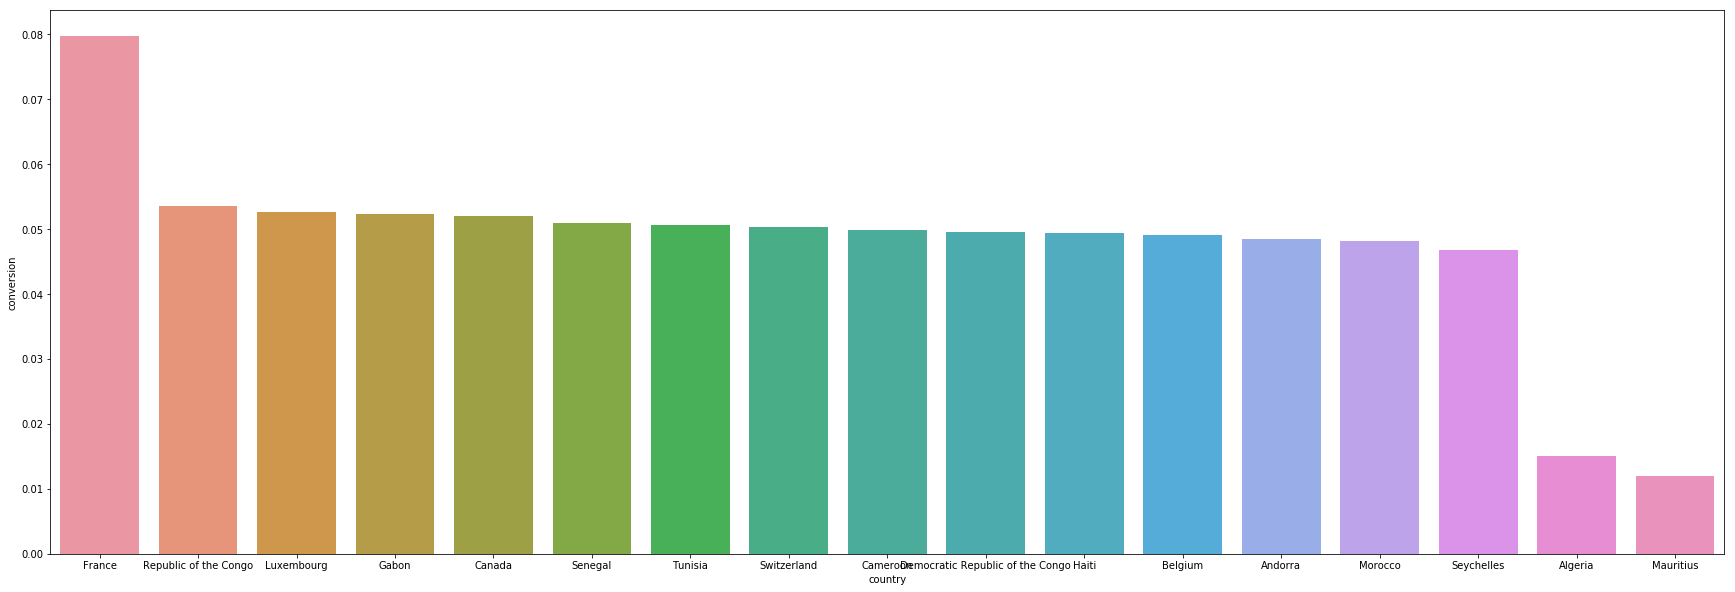

In [186]:
# First check that france converts much better than the rest of LatAm countries
groupby_country = data[data['test'] == 0][['conversion', 'country']].groupby('country').mean()
groupby_country = groupby_country.reset_index()
groupby_country = groupby_country.sort_values('conversion', ascending=False)

# Visualization
fig, ax = plt.subplots(figsize=(30,10))
sns.barplot(x='country', y='conversion', data=groupby_country, ax=ax)
plt.show()

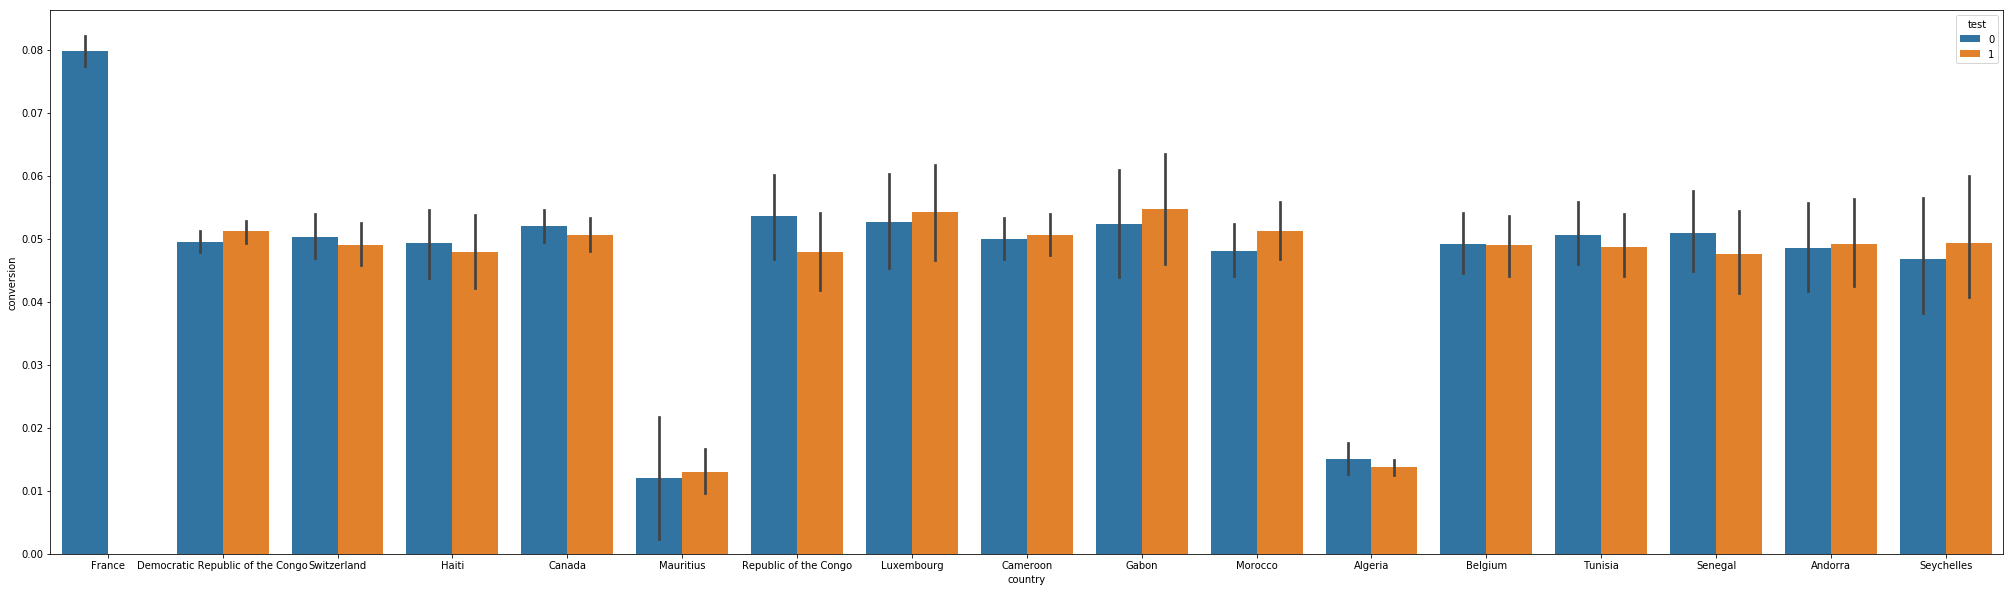

In [187]:
# Visualization
fig, ax = plt.subplots(figsize=(35, 10))
sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax)
plt.show()

Eventually, let's remove France and samples that have missing country values from the dataset because:

Nothing has changed for France
Number of missing values is small, so they won't affect statistical tests much


In [188]:
data = data[(data.country != 'France') & (data.country != 'missing')]
data.shape

(401539, 12)

# Two-sample Z-test on entire dataset

When testing whether the conversion rate is statistically different between the experiment and the control groups, we usually apply a two-sample proportion test. Options include Chi-square test, Z-test, etc. When the sample size is large, these tests lead to the same statistical result, i.e. P-value. I chose to use Z-test here because our sample size is sufficiently large.

The team's assumption is:

H0: Conversion rate_experiment group = Conversion rate_control group

H1: Conversion rate_experiment group < Conversion rate_control group

First, let's subset the data into an experiment group and a control group

In [189]:
experiment_group = data[(data.test == 1)]
control_group = data[(data.test == 0)]

We can see from below that initial comparison of the conversion rates between the experiment and the control groups indicates that the non-localized translation was doing better.

In [190]:
control_group.conversion.mean()

0.04833042316066309

In [191]:
experiment_group.conversion.mean()

0.043424713982118966

In [192]:
import statsmodels.api as sm
def two_sample_z_test(df, alternative='two-sided'):
    """
    This function returns the P-value from a two-sample Z-test
    """
    test_df = df[df.test == 1]
    control_df = df[df.test == 0]

    test_convert = test_df.conversion.sum()
    control_convert = control_df.conversion.sum()

    test_n = len(test_df.conversion)
    control_n = len(control_df.conversion)
    z, p_value = sm.stats.proportions_ztest([test_convert, control_convert], 
                                            [test_n, control_n],
                                           alternative=alternative)
    return(z, p_value)

z, pvalue = two_sample_z_test(data, alternative='smaller')
print('Z-score is: {}'.format(z))
print('P-value is: {}'.format(pvalue))

Z-score is: -7.422021422012666
P-value is: 5.767307540762427e-14


From the test result we see that what the team observed was true, the conversion rate of the test group is indeed less than that of the control group.

#  Conversion rate by variable

Is there any confounding variable?

A confounding variable is an outside influence
that changes the effect of an independent variable
on the dependent variable

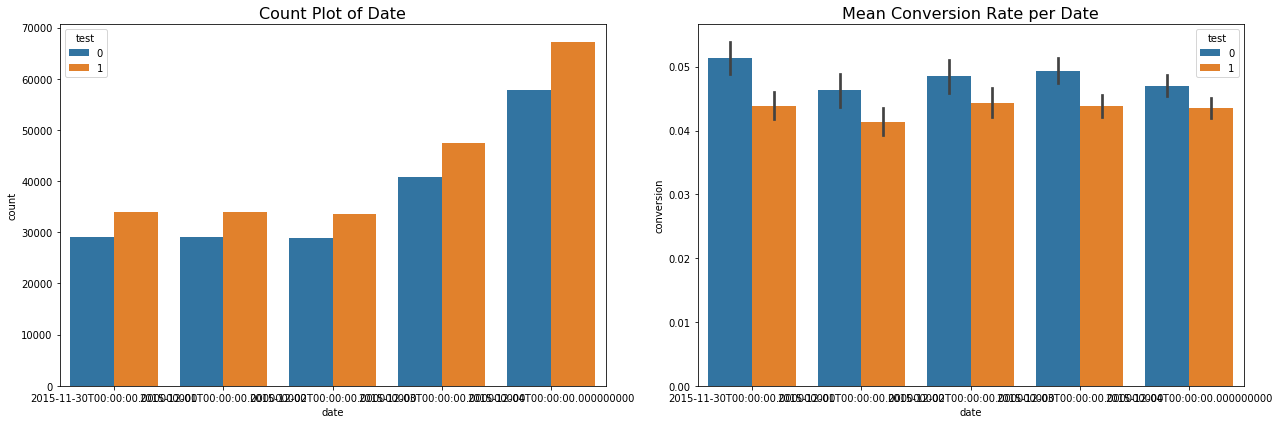

In [203]:
# Visualization of different dates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='date', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Date', fontsize=16)

sns.barplot(x='date', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Date', fontsize=16)
plt.tight_layout()
plt.show()

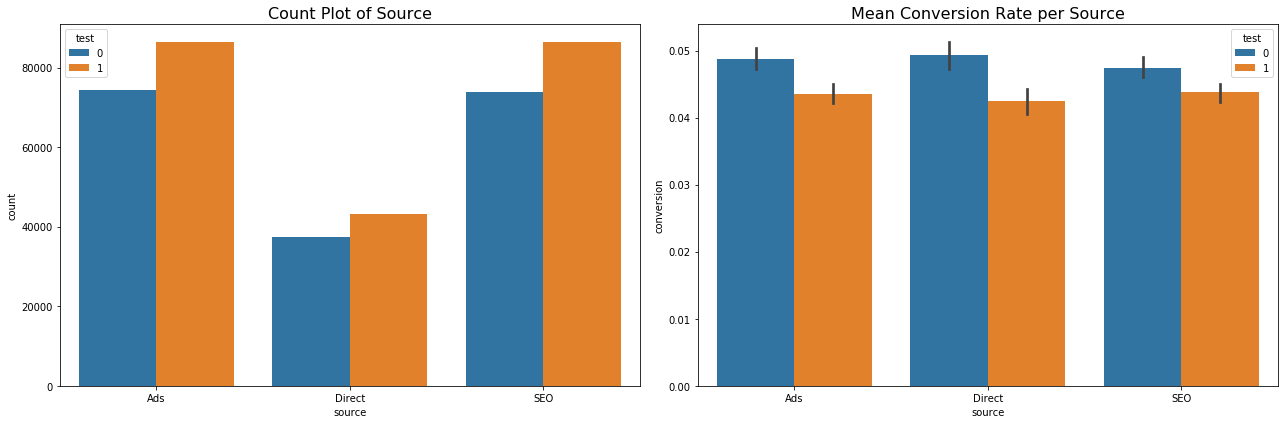

In [204]:
# Visualization of different source
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)

sns.barplot(x='source', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

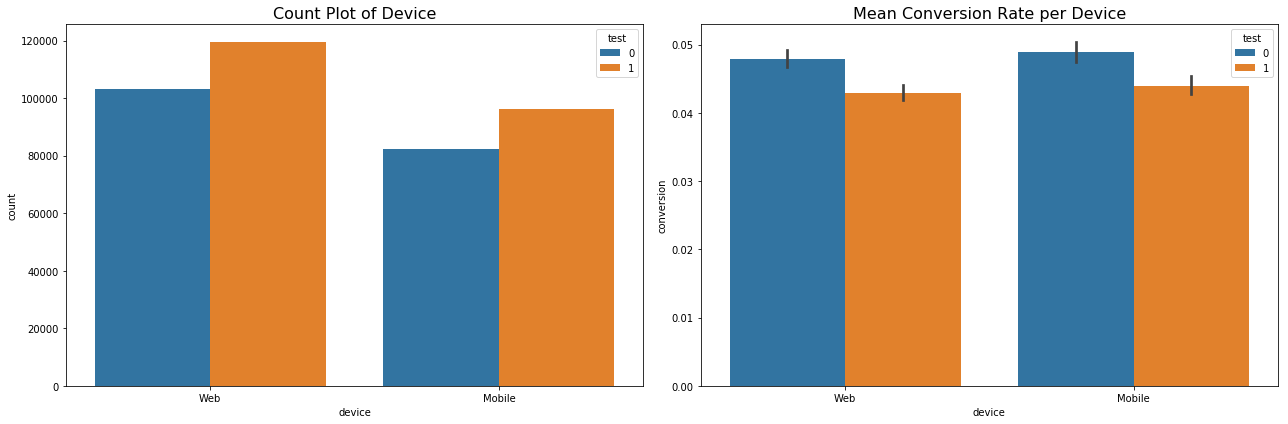

In [205]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='device', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Device', fontsize=16)

sns.barplot(x='device', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Device', fontsize=16)
plt.tight_layout()
plt.show()

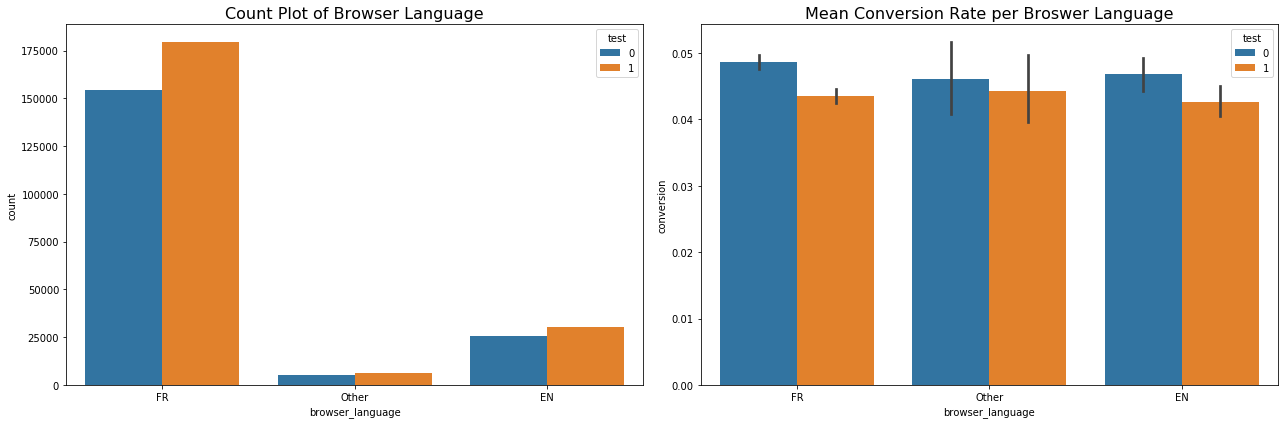

In [206]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser_language', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Browser Language', fontsize=16)

sns.barplot(x='browser_language', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Broswer Language', fontsize=16)
plt.tight_layout()
plt.show()

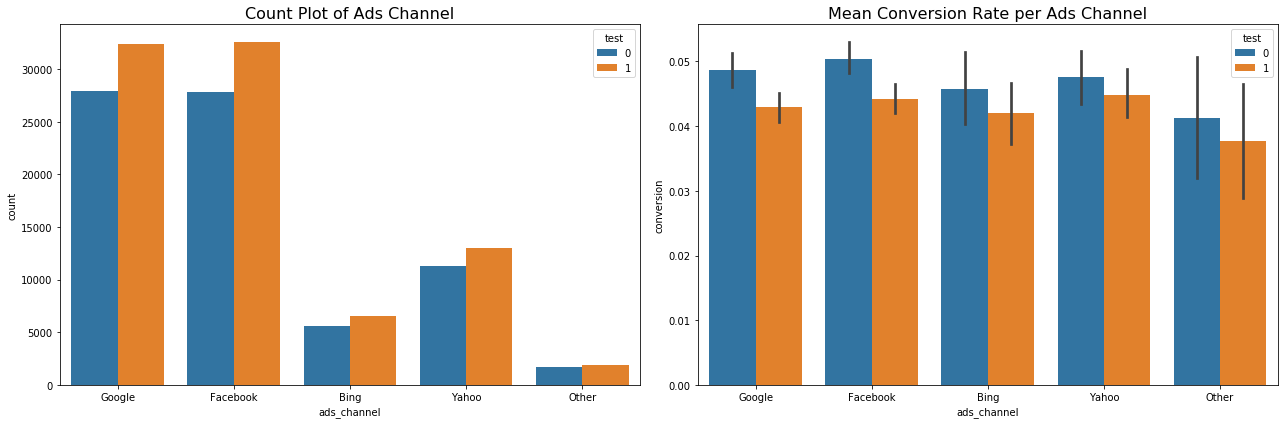

In [207]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='ads_channel', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Ads Channel', fontsize=16)

sns.barplot(x='ads_channel', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Ads Channel', fontsize=16)
plt.tight_layout()
plt.show()

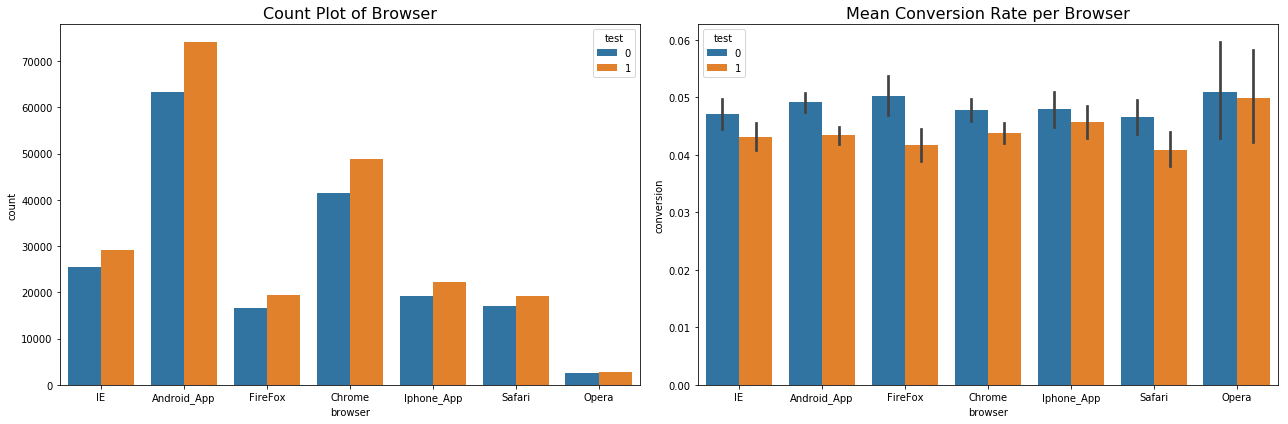

In [208]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Browser', fontsize=16)

sns.barplot(x='browser', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Browser', fontsize=16)
plt.tight_layout()
plt.show()

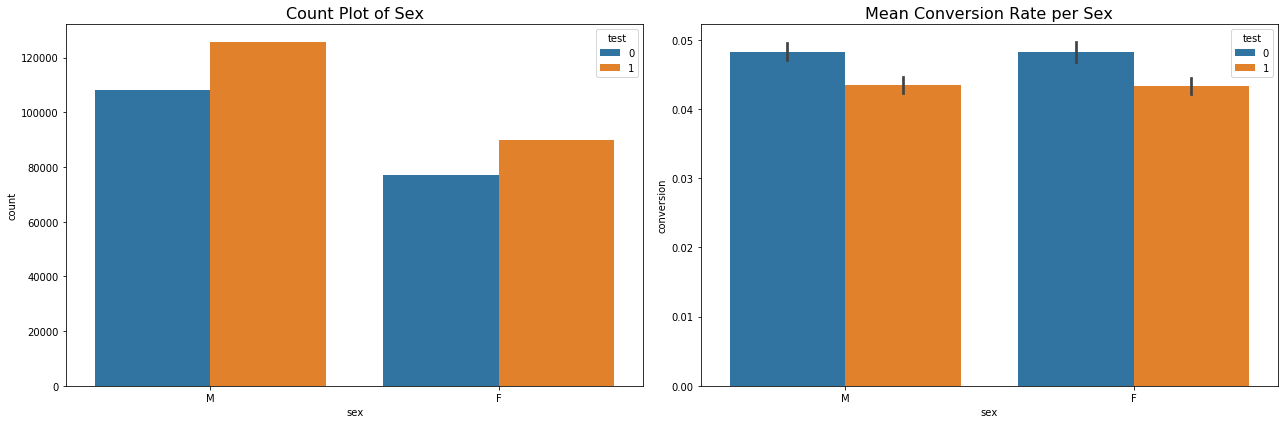

In [209]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize=16)

sns.barplot(x='sex', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Sex', fontsize=16)
plt.tight_layout()
plt.show()

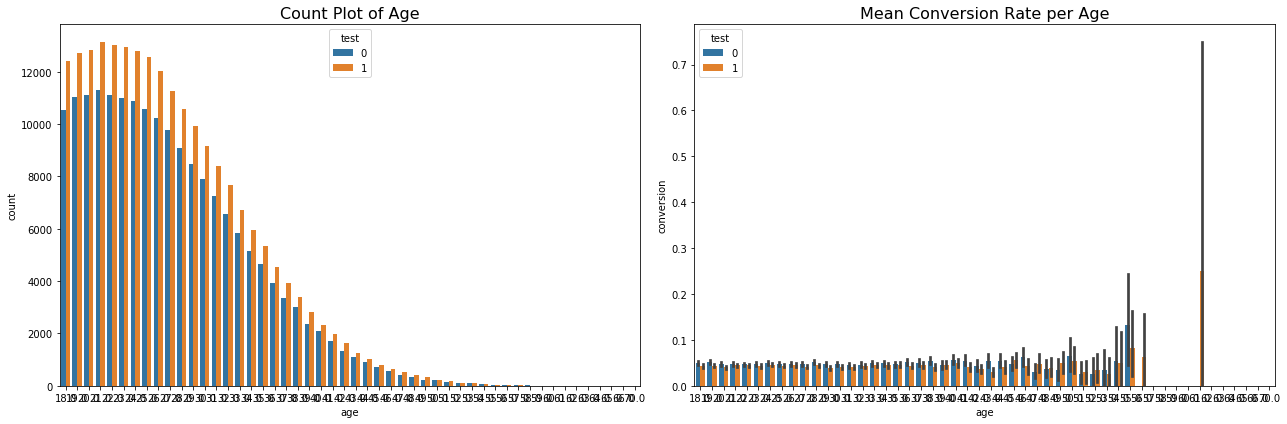

In [210]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='age', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Age', fontsize=16)

sns.barplot(x='age', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Age', fontsize=16)
plt.tight_layout()
plt.show()

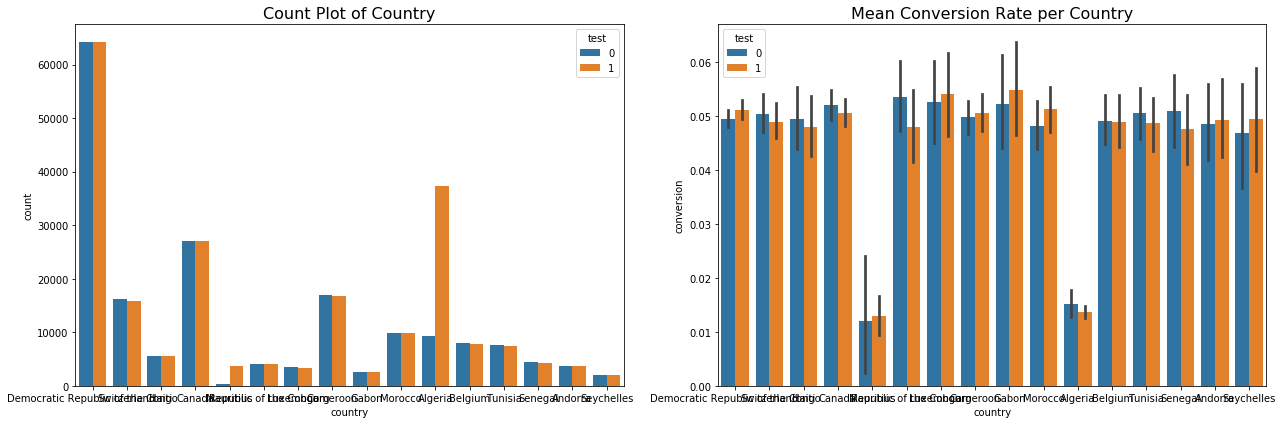

In [211]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)

sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

We have identified that country may be a confounding factor that influences the coversion rate. In next section, let's dive deeper into this variable.

## Conversion rate by country

In this section, let's look at conversion rate by country and check how many countries have a higher conversion rate in the experiment group than the control.

From the table below, we see that several countries have a higher conversion rate in the experiment group.

In [124]:
conversion_by_country = data.groupby(['country', 'test']).conversion.mean().reset_index()
conversion_by_country

,country,test,conversion
0,Algeria,0,0.015071
1,Algeria,1,0.013725
2,Andorra,0,0.048493
3,Andorra,1,0.049229
4,Belgium,0,0.049154
5,Belgium,1,0.048988
6,Cameroon,0,0.049914
7,Cameroon,1,0.050604
8,Canada,0,0.052089
9,Canada,1,0.050571


In [125]:
data.groupby(['country', 'test']).conversion.count()

country                           test
Algeria                           0        9356
                                  1       37377
Andorra                           0        3650
                                  1        3697
Belgium                           0        8036
                                  1        7859
Cameroon                          0       16869
                                  1       16797
Canada                            0       27088
                                  1       26972
Democratic Republic of the Congo  0       64209
                                  1       64275
Gabon                             0        2660
                                  1        2649
Haiti                             0        5550
                                  1        5574
Luxembourg                        0        3419
                                  1        3304
Mauritius                         0         415
                                  1        3719
M

In [127]:
data.groupby(['country', 'test']).conversion.sum()

country                           test
Algeria                           0        141
                                  1        513
Andorra                           0        177
                                  1        182
Belgium                           0        395
                                  1        385
Cameroon                          0        842
                                  1        850
Canada                            0       1411
                                  1       1364
Democratic Republic of the Congo  0       3178
                                  1       3290
Gabon                             0        139
                                  1        145
Haiti                             0        274
                                  1        267
Luxembourg                        0        180
                                  1        179
Mauritius                         0          5
                                  1         48
Morocco              

Overall, we found that 27% of countries have higher conversion rates in the experiment group than the control group. But are these differences statistically significant?

In [134]:
tol = 0
for i in range(1, len(conversion_by_country.conversion),2):
        if conversion_by_country.conversion[i] > conversion_by_country.conversion[i - 1]:
            tol += 1
print('Proportion of countries that have a higher conversion rate in the experiment group: {}'.\
      format(tol/len(conversion_by_country.conversion)))

Proportion of countries that have a higher conversion rate in the experiment group: 0.2727272727272727


Next, let's use a Z-test to check whether the difference of conversion rates are statistically significant. We have the following hypotheses: 

H0: Conversion rate experiment group = Conversion rate control group

H1: Conversion rate experiment group} < Conversion rate control group

When performing a two-sided Z-test for each country where, we found that all p-values are above the 0.05 significance level, therefore, we cannot reject the null hypothesis mentioned above.





In [173]:
country_df = data.groupby(['country'])
pvalue_df = country_df.apply(lambda x: two_sample_z_test(x, 'smaller')[1]).reset_index()
pvalue_df.columns = [u'country', 'pvalue']
pvalue_df

,country,pvalue
0,Algeria,0.160878
1,Andorra,0.558159
2,Belgium,0.480755
3,Cameroon,0.614029
4,Canada,0.211862
5,Democratic Republic of the Congo,0.917228
6,Gabon,0.656102
7,Haiti,0.359424
8,Luxembourg,0.609844
9,Mauritius,0.558611


## Conclusion: Localized translation didn't worsen the conversion rate.

Ariel Negrin